# Quantum Convolutional Neural Network for MNIST Classification

This notebook demonstrates the use of a Quantum Convolutional Neural Network (QCNN) to perform binary classification on the MNIST dataset [2]. We focus on distinguishing between the digits '0' and '1' using a quantum approach.

In [1]:
import pennylane as qml
import pennylane.numpy as pnp
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## Data Loading and Preprocessing

We begin by loading the MNIST dataset and preprocessing it for use with our quantum circuit:

- **Flattening and Normalization**: The images are flattened and normalized to fit within the range $[0, \pi]$, suitable for quantum angle embedding.
- **Dimensionality Reduction**: The data is reduced to match the size of our quantum circuit, which uses 4 qubits.
- **Binary Labels**: The labels are converted to binary, focusing on the digits '0' and '1' for classification.

In [2]:
def load_and_preprocess_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    # Flatten the images
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)
    
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, pnp.pi))
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    # Reduce dimensionality to match our circuit size
    x_train = x_train[:, :n_qubits]
    x_test = x_test[:, :n_qubits]
    
    # Convert labels to binary (0 and 1)
    y_train = (y_train == 1).astype(int)
    y_test = (y_test == 1).astype(int)
    
    return x_train, y_train, x_test, y_test

## Quantum Circuit Design

The Quantum Convolutional Neural Network (QCNN) is constructed using specialized quantum layers that leverage the unique properties of quantum mechanics to process data. The design includes quantum convolutional and pooling layers, each playing a distinct role in the network.

### Quantum Convolutional Layer

The quantum convolutional layer is designed to extract features from the input data by applying parameterized quantum gates:

- **Parameterized Rotations**: Each qubit undergoes a rotation about the Y-axis (RY gate), controlled by trainable parameters. These rotations adjust the state of each qubit, allowing the circuit to adapt to different input patterns.
- **Entanglement via CNOT Gates**: Circular nearest neighbor interactions are used to entangle adjacent qubits. This is achieved using CNOT gates, which create correlations between qubits, enabling the circuit to capture complex dependencies in the data.

The combination of parameterized rotations and entanglement allows the quantum convolutional layer to perform operations analogous to classical convolutional layers, extracting meaningful features from the input.

### Quantum Pooling Layer

The quantum pooling layer reduces the dimensionality of the data while preserving essential information, similar to pooling operations in classical neural networks:

- **Controlled Rotations (CRZ and CRX Gates)**: These gates are used to further entangle qubits and introduce non-linearity into the circuit. The CRZ gate applies a rotation about the Z-axis controlled by another qubit, while the CRX gate applies a rotation about the X-axis.
- **Pauli-X Gates**: These gates are applied to certain qubits to flip their states, adding another layer of complexity and transformation to the quantum data.

The pooling layer effectively reduces the number of active qubits while maintaining the integrity of the data's most important features. This reduction is crucial for managing the circuit's complexity and ensuring efficient computation.

### Overall Circuit Architecture

The QCNN alternates between these convolutional and pooling layers, gradually transforming the input data into a form that can be used for classification. The design leverages the power of quantum entanglement and superposition to process information in ways that classical networks cannot, potentially offering advantages in terms of computational efficiency and expressiveness.

By understanding the role of each layer, we can appreciate how the QCNN processes data and adapts to the specific task of image classification.

In [3]:
n_qubits = 4
n_layers = int(pnp.log2(n_qubits)) 

dev = qml.device("default.qubit", wires=n_qubits)

def circular_nearest_neighbor(wires):
    edges = []
    seen = set()
    for i in range(len(wires)):
        a, b = i, (i + 1) % len(wires)
        if (b, a) not in seen:
            edges.append((a, b))
            seen.add((a, b))
    return edges

def quantum_conv_layer(params, wires):
    for wire1, wire2 in circular_nearest_neighbor(wires):
        qml.RY(params[0], wires=wire1)
        qml.RY(params[1], wires=wire2)
        qml.CNOT(wires=[wire1, wire2])

def quantum_pool_layer(params, wires):
    for wire1, wire2 in circular_nearest_neighbor(wires):
        qml.CRZ(params[0], wires=[wire1, wire2])
        qml.PauliX(wires=wire1)
        qml.CRX(params[1], wires=[wire1, wire2])
        qml.PauliX(wires=wire1)

@qml.qnode(dev)
def qcnn_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    
    weight_idx = 0
    for layer in reversed(range(n_layers)):
        n_active = 2 ** (layer + 1)
        active_wires = list(range(n_qubits - n_active, n_qubits))
        
        quantum_conv_layer(weights[weight_idx:weight_idx+n_active], wires=active_wires)
        weight_idx += n_active
        qml.Barrier(wires=range(n_qubits))
        
        quantum_pool_layer(weights[weight_idx:weight_idx+n_active], wires=active_wires)
        weight_idx += n_active
        qml.Barrier(wires=range(n_qubits))
    
    return qml.expval(qml.PauliZ(0))

### Quantum Circuit Visualization

To better understand the structure and flow of operations within the Quantum Convolutional Neural Network (QCNN), we visualize the quantum circuit using dummy inputs and weights.

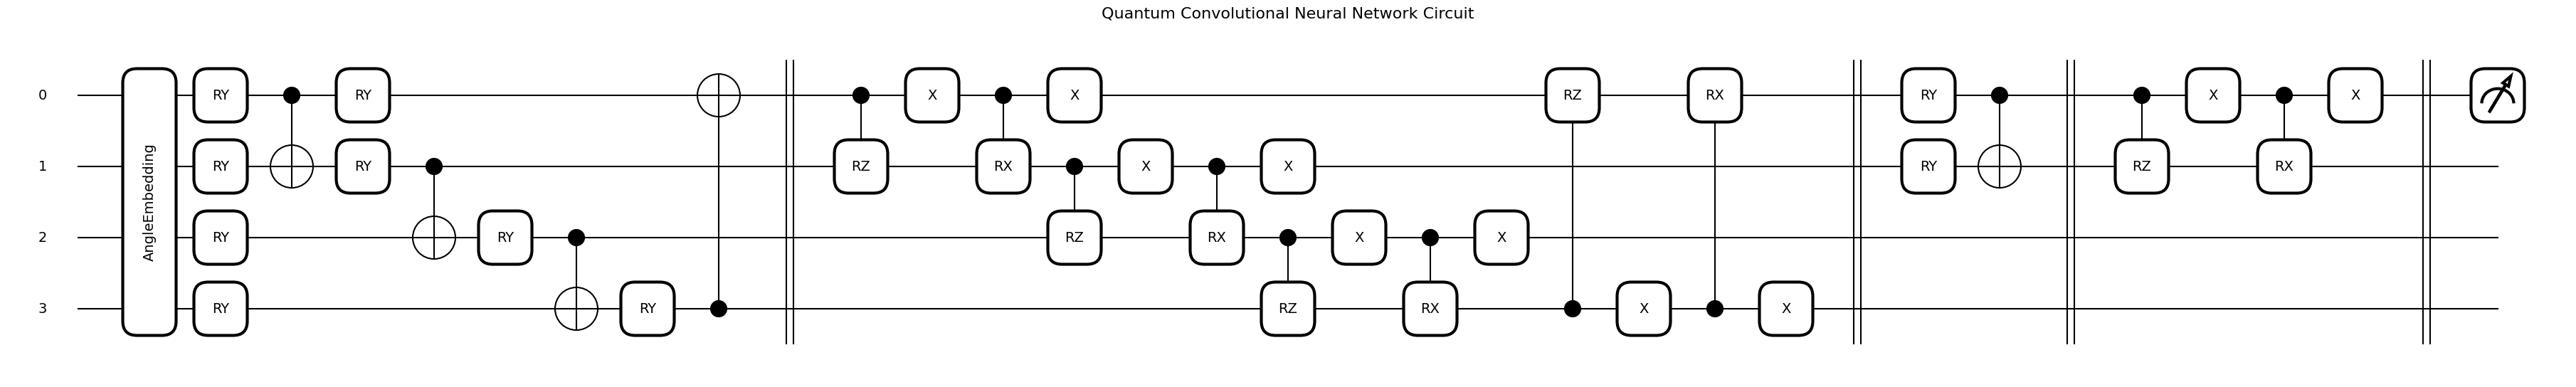

In [4]:
dummy_inputs = pnp.zeros(n_qubits)
total_params = 4 * n_qubits - 4
dummy_weights = pnp.zeros(total_params)

fig, ax = qml.draw_mpl(qcnn_circuit)(dummy_inputs, dummy_weights)
plt.title("Quantum Convolutional Neural Network Circuit", fontsize=16)
plt.show()

#### Quantum Neural Network Function

The `quantum_net` function adjusts the output of the QCNN circuit to lie within the range [0, 1]. This is achieved by scaling the output, which originally ranges from [-1, 1], to match the probability interpretation required for binary classification.

#### Cross-Entropy Loss

The `cross_entropy` function calculates the cross-entropy loss, a standard metric for evaluating the performance of classification models. It measures the difference between the predicted probabilities and the true labels.The cross-entropy loss for a single prediction is given by:

  $$
  \text{Loss} = -\left(y \log(\hat{y}) + (1 - y) \log(1 - \hat{y})\right)
  $$

  where $ y $ is the true label and $ \hat{y} $ is the predicted probability.To prevent numerical instability, predictions are clipped to a small range using `epsilon`, ensuring that log operations do not encounter undefined values.

#### Cost Function

The `cost` function computes the average cross-entropy loss over a batch of inputs. It first generates predictions using the `quantum_net` function and then evaluates the loss against the true labels. The cost function is defined as:

  $$
  \text{Cost} = \frac{1}{n} \sum_{i=1}^{n} \left( -y_i \log(\hat{y}_i) - (1 - y_i) \log(1 - \hat{y}_i) \right)
  $$

  where $ n $ is the number of samples, $ y_i $ is the true label, and $ \hat{y}_i $ is the predicted probability for the $ i $-th sample. This cost function serves as the objective to be minimized during the training process, guiding the optimization of the QCNN's parameters to improve classification accuracy.

In [5]:
def quantum_net(inputs, weights):
    return (qcnn_circuit(inputs, weights) + 1) / 2

def cross_entropy(predictions, labels):
    epsilon = 1e-15
    predictions = pnp.clip(predictions, epsilon, 1 - epsilon)
    return -pnp.mean(labels * pnp.log(predictions) + (1 - labels) * pnp.log(1 - predictions))

def cost(weights, inputs, labels):
    predictions = pnp.array([quantum_net(x, weights) for x in inputs])
    return cross_entropy(predictions, labels)

#### Data Preprocessing

We load and preprocess the MNIST dataset, focusing on binary classification for the digits '0' and '1'. Only samples labeled as '0' or '1' are selected, reducing the problem to a binary classification task. The data is split into training and validation sets, with 20% of the data reserved for validation. This split helps in monitoring the model's performance and preventing overfitting during training.


In [6]:
total_params = 4 * n_qubits - 4  # Total number of parameters needed
weights = pnp.random.uniform(0, 2*pnp.pi, total_params, requires_grad=True)

x_train, y_train, x_test, y_test = load_and_preprocess_mnist()

# We'll use only two classes for binary classification (0 and 1)
train_indices = pnp.where((y_train == 0) | (y_train == 1))[0]
x_train = x_train[train_indices]
y_train = y_train[train_indices]

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

### Training the QCNN

This training strategy ensures that the QCNN is optimized effectively while avoiding overfitting, leading to a model that generalizes well to unseen data.

#### Optimization Setup

The Adam optimizer is used with a learning rate (stepsize) of 0.001. This adaptive optimizer is well-suited for handling the sparse gradients typical in quantum neural networks. Training is performed in mini-batches of size 32, over a total of 5000 steps. Mini-batch training helps in efficient convergence and reduces memory usage.

#### Training Loop

In each iteration, a random batch of training data is selected for updating the weights. Every 100 steps, the training and validation costs are calculated and recorded. These metrics help monitor the model's performance over time.

#### Early Stopping

The validation cost is tracked to identify the best-performing model. If the validation cost does not improve for 10 consecutive evaluations (patience), training is stopped early to prevent overfitting. The weights corresponding to the lowest validation cost are saved as the best model parameters.

In [7]:
opt = qml.AdamOptimizer(stepsize=0.001)
batch_size = 32
steps = 5000

best_val_cost = float('inf')
patience = 10
no_improvement = 0

train_costs = []
val_costs = []

for i in range(steps):
    batch_indices = pnp.random.choice(len(x_train), batch_size, replace=False)
    x_batch = x_train[batch_indices]
    y_batch = y_train[batch_indices]
    
    weights = opt.step(lambda w: cost(w, x_batch, y_batch), weights)
    
    if (i + 1) % 100 == 0:
        train_cost = cost(weights, x_train, y_train)
        val_cost = cost(weights, x_val, y_val)
        train_costs.append(train_cost)
        val_costs.append(val_cost)

        train_cost = pnp.round(train_cost, 3)
        val_cost = pnp.round(val_cost, 3)

        print(f"Step {i+1}, Train Cost: {train_cost:.3f}, Validation Cost: {val_cost:.3f}")
        
        if val_cost < best_val_cost:
            best_val_cost = val_cost
            best_weights = weights
            no_improvement = 0
        else:
            no_improvement += 1
        
        if no_improvement >= patience:
            print(f"Early stopping at step {i+1}")
            break

Step 100, Train Cost: 0.650, Validation Cost: 0.650
Step 200, Train Cost: 0.591, Validation Cost: 0.590
Step 300, Train Cost: 0.542, Validation Cost: 0.541
Step 400, Train Cost: 0.507, Validation Cost: 0.506
Step 500, Train Cost: 0.482, Validation Cost: 0.480
Step 600, Train Cost: 0.458, Validation Cost: 0.455
Step 700, Train Cost: 0.439, Validation Cost: 0.437
Step 800, Train Cost: 0.429, Validation Cost: 0.426
Step 900, Train Cost: 0.422, Validation Cost: 0.420
Step 1000, Train Cost: 0.418, Validation Cost: 0.415
Step 1100, Train Cost: 0.414, Validation Cost: 0.411
Step 1200, Train Cost: 0.410, Validation Cost: 0.407
Step 1300, Train Cost: 0.405, Validation Cost: 0.402
Step 1400, Train Cost: 0.401, Validation Cost: 0.398
Step 1500, Train Cost: 0.397, Validation Cost: 0.394
Step 1600, Train Cost: 0.393, Validation Cost: 0.389
Step 1700, Train Cost: 0.388, Validation Cost: 0.384
Step 1800, Train Cost: 0.382, Validation Cost: 0.378
Step 1900, Train Cost: 0.373, Validation Cost: 0.369
St

### Cost History Plot

The cost history plot provides a visual representation of the training and validation costs over the course of the optimization process. This plot is crucial for understanding the model's learning dynamics and assessing its performance.

The cost history plot demonstrates effective optimization of the Quantum Convolutional Neural Network (QCNN), with both training and validation costs decreasing and stabilizing over time. The use of early stopping ensures that the model maintains a balance between fitting the training data and generalizing to new inputs, resulting in a robust classifier for the binary classification task.

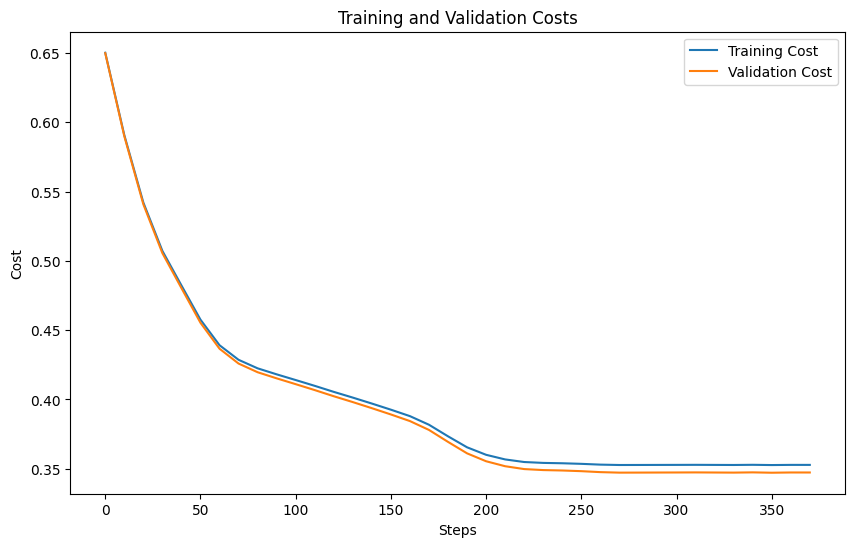

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(range(0, len(train_costs)*10, 10), train_costs, label='Training Cost')
plt.plot(range(0, len(val_costs)*10, 10), val_costs, label='Validation Cost')
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.title('Training and Validation Costs')
plt.legend()
plt.show()

#### Test Accuracy

The QCNN achieves a test accuracy of 88.65%. This indicates that the model correctly classifies approximately 88.65% of the test samples, demonstrating its effectiveness in distinguishing between the digits '0' and '1'.

#### Sample Predictions


The model consistently predicts the digit '0' for the majority of the samples, with a probability of approximately 0.1195. This suggests a bias towards predicting '0', which may affect its performance on samples labeled as '1'. In the provided samples, the model incorrectly predicts '0' for some instances where the true label is '1'. This highlights an area for potential improvement, where the model could benefit from further tuning or additional data preprocessing to better capture the features distinguishing '0' from '1'.

While the QCNN demonstrates a high overall accuracy, the sample predictions reveal a tendency to favor one class over the other. Addressing this bias could lead to further enhancements in the model's performance, ensuring a more balanced and accurate classification across both classes.

In [13]:
test_predictions = pnp.array([quantum_net(x, best_weights) for x in x_test])
test_predictions = (test_predictions > 0.5).astype(int)
accuracy = pnp.mean(test_predictions == y_test)
print(f"Test Accuracy: {accuracy:.4f}")

print("\nSample Predictions:")
for i in range(10):
    true_label = y_test[i]
    predicted_prob = quantum_net(x_test[i], best_weights)
    predicted_label = int(predicted_prob > 0.5)
    print(f"True: {true_label}, Predicted: {predicted_label} (Probability: {predicted_prob:.4f})")

Test Accuracy: 0.8865

Sample Predictions:
True: 0, Predicted: 0 (Probability: 0.1188)
True: 0, Predicted: 0 (Probability: 0.1188)
True: 1, Predicted: 0 (Probability: 0.1188)
True: 0, Predicted: 0 (Probability: 0.1188)
True: 0, Predicted: 0 (Probability: 0.1188)
True: 1, Predicted: 0 (Probability: 0.1188)
True: 0, Predicted: 0 (Probability: 0.1188)
True: 0, Predicted: 0 (Probability: 0.1188)
True: 0, Predicted: 0 (Probability: 0.1188)
True: 0, Predicted: 0 (Probability: 0.1188)


## References

[1] Tak Hur, Leeseok Kim & Daniel K. Park (2022). Quantum convolutional neural network for classical data classification. *Quantum Machine Intelligence, 3*(1), 1-9. [https://link.springer.com/article/10.1007/s42484-021-00061-x](https://link.springer.com/article/10.1007/s42484-021-00061-x).

[2] LeCun, Y., Cortes, C., & Burges, C. J. (2010). MNIST handwritten digit database. *ATT Labs [Online]. Available: [http://yann.lecun.com/exdb/mnist](http://yann.lecun.com/exdb/mnist)*.
